About Dataset
Context

The SMS Spam Collection is a set of SMS tagged messages that have been collected for SMS Spam research. It contains one set of SMS messages in English of 5,574 messages, tagged acording being ham (legitimate) or spam.

Content

The files contain one message per line. Each line is composed by two columns: v1 contains the label (ham or spam) and v2 contains the raw text.

This corpus has been collected from free or free for research sources at the Internet:

-> A collection of 425 SMS spam messages was manually extracted from the Grumbletext Web site. This is a UK forum in which cell phone users make public claims about SMS spam messages, most of them without reporting the very spam message received. The identification of the text of spam messages in the claims is a very hard and time-consuming task, and it involved carefully scanning hundreds of web pages. The Grumbletext Web site is: [Web Link].
-> A subset of 3,375 SMS randomly chosen ham messages of the NUS SMS Corpus (NSC), which is a dataset of about 10,000 legitimate messages collected for research at the Department of Computer Science at the National University of Singapore. The messages largely originate from Singaporeans and mostly from students attending the University. These messages were collected from volunteers who were made aware that their contributions were going to be made publicly available. The NUS SMS Corpus is avalaible at: [Web Link].
-> A list of 450 SMS ham messages collected from Caroline Tag's PhD Thesis available at [Web Link].
-> Finally, we have incorporated the SMS Spam Corpus v.0.1 Big. It has 1,002 SMS ham messages and 322 spam messages and it is public available at: [Web Link]. This corpus has been used in the following academic researches:

Acknowledgements

The original dataset can be found here. The creators would like to note that in case you find the dataset useful, please make a reference to previous paper and the web page: http://www.dt.fee.unicamp.br/~tiago/smsspamcollection/ in your papers, research, etc.

We offer a comprehensive study of this corpus in the following paper. This work presents a number of statistics, studies and baseline results for several machine learning methods.

Almeida, T.A., GÃ³mez Hidalgo, J.M., Yamakami, A. Contributions to the Study of SMS Spam Filtering: New Collection and Results. Proceedings of the 2011 ACM Symposium on Document Engineering (DOCENG'11), Mountain View, CA, USA, 2011.

Inspiration

Can you use this dataset to build a prediction model that will accurately classify which texts are spam?

In [192]:
import pandas as pd
import numpy as np
import re, os
from collections import Counter
import joblib

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    precision_score, recall_score, f1_score, roc_auc_score, auc,
    precision_recall_curve, classification_report, confusion_matrix
)
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("data.csv")
df = df.iloc[:, :2].rename(columns={'v1' : 'label', 'v2' : 'message'})
df['label'] = df['label'].replace({'ham' : 0, 'spam' : 1})
# df.isna().sum()
df = df.dropna().drop_duplicates()

/var/folders/3z/h7_y2tw90bd9_d3j8sfghz_00000gn/T/ipykernel_19171/2921685770.py:24: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['label'] = df['label'].replace({'ham' : 0, 'spam' : 1})


In [194]:
df['label'] = df['label'].replace({'ham' : 0, 'spam' : 1})

In [195]:
df.isna().sum()

label      0
message    0
dtype: int64

#### Дисбаланс классов

In [196]:
print(df['label'].value_counts(normalize=True))

label
0    0.87367
1    0.12633
Name: proportion, dtype: float64


## Feature Engineering

#### Базовые признаки

In [197]:
df['text_len'] = df['message'].str.len()
df['word_num'] = df['message'].str.split().apply(lambda x: len(x))
df['dig_num'] = df['message'].str.count(r"\d")
df['caps_ratio'] = df['message'].apply(lambda x : sum([i.isupper() for i in x]) / len(x))
df['num_special'] = df['message'].str.count(r"[^\w\s]")
df['num_words'] = df['message'].str.split().str.len()
df['num_money'] = df['message'].str.count(r'\$|€|£|usd|eur').astype(int)

In [198]:
df

,label,message,text_len,word_num,dig_num,caps_ratio,num_special,num_words,num_money
0,0,"Go until jurong point, crazy.. Available only ...",111,20,0,0.027027,9,20,0
1,0,Ok lar... Joking wif u oni...,29,6,0,0.068966,6,6,0
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,28,25,0.064516,6,28,0
3,0,U dun say so early hor... U c already then say...,49,11,0,0.040816,6,11,0
4,0,"Nah I don't think he goes to usf, he lives aro...",61,13,0,0.032787,2,13,0
...,...,...,...,...,...,...,...,...,...
5567,1,This is the 2nd time we have tried 2 contact u...,161,30,21,0.062112,8,30,0
5568,0,Will М_ b going to esplanade fr home?,37,8,0,0.054054,1,8,0
5569,0,"Pity, * was in mood for that. So...any other s...",57,10,0,0.035088,7,10,0
5570,0,The guy did some bitching but I acted like i'd...,125,26,0,0.016000,1,26,0


#### OSINT

In [199]:
url_pattern = r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+])+'

df['url_count'] = df['message'].apply(lambda x : len(re.findall(url_pattern, x)))
df['urls'] = df['message'].apply(lambda x : re.findall(url_pattern, x))

In [200]:
phone_pattern = r"\+?\d[\d\-\s]{7,}\d"
df['phone_count'] = df['message'].apply(lambda x : len(re.findall(phone_pattern, x)))

In [201]:
def url_features(urls):
    if not urls:
        return 0, 0
    url = urls[0]  # берём первый URL

    suspicious_tlds = ('.xyz', '.top', '.club', '.online', '.site', '.work', '.date') # Подозрительные домены верхнего уровня
    tld_suspicious = 1 if any(tld in url for tld in suspicious_tlds) else 0

    # Длина домена
    domain_match = re.search(r'://([^/]+)', url)
    domain_len = len(domain_match.group(1)) if domain_match else 0
    return tld_suspicious, domain_len # подозрительный TLD, длина домена

df[['suspicious_tld', 'domain_len']] = df['urls'].apply(lambda urls: pd.Series(url_features(urls)))

##### Очистка текста

In [202]:
def clean_text(text):
    text = text.lower()
    text = re.sub(url_pattern, " URL ", text)  # заменяем ссылки
    text = re.sub(phone_pattern, " PHONE ", text)  # заменяем ссылки
    text = re.sub(r"\d+", " NUM ", text)               # числа
    text = re.sub(r"[^\w\s]", " ", text)               # пунктуация
    text = re.sub(r"\s+", " ", text).strip()
    return text

df['message'] = df['message'].apply(clean_text)

Поиск популярных для спама слов (без учета просто популярных)

In [203]:
from collections import Counter

spam_messanges = df.loc[df['label'].eq(1), 'message'].apply(lambda x : re.findall('[a-zA-Z]+', x))
spam_words_count = Counter()
for m in spam_messanges:
    spam_words_count.update(m)
spam_words = set([el for el, count in spam_words_count.most_common(50)])

non_spam_messanges = df.loc[df['label'].eq(0), 'message'].apply(lambda x : re.findall('[a-zA-Z]+', x))
non_spam_words_count = Counter()
for m in non_spam_messanges:
    non_spam_words_count.update(m)
non_spam_words = set([el for el, count in non_spam_words_count.most_common(100)])

fraud_keywords = spam_words - non_spam_words

def count_spam_words (text):
    c = 0
    for word in text.split():
        if word in fraud_keywords:
            c+=1
    return(c)
df['spam_words_count'] = df['message'].apply(count_spam_words)

In [204]:
fraud_keywords

{'PHONE',
 'c',
 'cash',
 'claim',
 'free',
 'mobile',
 'new',
 'nokia',
 'our',
 'p',
 'prize',
 'reply',
 'stop',
 'text',
 'txt',
 'uk',
 'urgent',
 'win',
 'won',
 'www'}

#### NLP-векторизация

TF-IDF

In [206]:
tfidf = TfidfVectorizer(max_features=2000, ngram_range=(1,2), stop_words='english', min_df=2)
X_tfidf = tfidf.fit_transform(df['message'])

# Cнижаем размерность до 20 компонент
svd = TruncatedSVD(n_components=50, random_state=42)
X_tfidf_reduced = svd.fit_transform(X_tfidf)

# Создаём DataFrame с компонентами
tfidf_cols = [f'tfidf_svd_{i}' for i in range(X_tfidf_reduced.shape[1])]
df_tfidf = pd.DataFrame(X_tfidf_reduced, columns=tfidf_cols)

df = pd.concat([df, df_tfidf], axis=1)

In [207]:
df = df.dropna().reset_index(drop=True) 

In [208]:
X = df.drop(['label', 'message', 'urls'], axis=1)
y = df['label']

#### ML

In [209]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [210]:
# Масштабирование числовых признаков
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

##### Логистическая регрессия

In [211]:
logreg = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
logreg.fit(X_train, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,'balanced'
,random_state,42
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


In [212]:
y_proba = logreg.predict_proba(X_test)[:, 1]
y_pred = logreg.predict(X_test)

print(f'Precision: {precision_score(y_test, y_pred):.4f}')
print(f'Recall:    {recall_score(y_test, y_pred):.4f}')
print(f'F1-score:  {f1_score(y_test, y_pred):.4f}')
print(f'ROC-AUC:   {roc_auc_score(y_test, y_proba):.4f}')

Precision: 0.8722
Recall:    0.9431
F1-score:  0.9062
ROC-AUC:   0.9813


In [213]:
print('\nClassification Report:')
print(classification_report(y_test, y_pred, target_names=['ham', 'spam']))


Classification Report:
              precision    recall  f1-score   support

         ham       0.99      0.98      0.99       841
        spam       0.87      0.94      0.91       123

    accuracy                           0.98       964
   macro avg       0.93      0.96      0.95       964
weighted avg       0.98      0.98      0.98       964



In [214]:
precision, recall, _ = precision_recall_curve(y_test, y_proba)
pr_auc = auc(recall, precision)

print("PR-AUC:", pr_auc)

PR-AUC: 0.9673201427714596


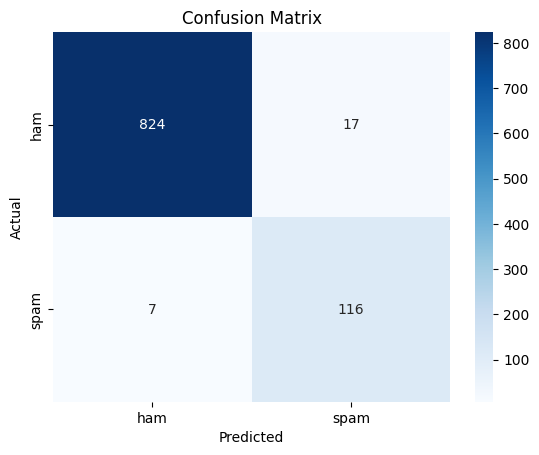

In [215]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['ham', 'spam'], yticklabels=['ham', 'spam'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [216]:
# Кросс-валидация для оценки устойчивости
cv_scores = cross_val_score(logreg, X, y, cv=5, scoring='roc_auc', n_jobs=-1)
print('CV ROC-AUC:', cv_scores.mean())

CV ROC-AUC: 0.9900173318363045


In [217]:

feature_names = X.columns.tolist()
coefficients = logreg.coef_[0]

# Сортируем по абсолютному значению
importance_df = pd.DataFrame({
    'feature': feature_names,
    'coef': coefficients,
    'abs_coef': np.abs(coefficients)
}).sort_values('abs_coef', ascending=False)

print('\nТоп самых влиятельных признаков:')
print(importance_df.head(10).to_string(index=False))


Топ самых влиятельных признаков:
         feature      coef  abs_coef
         dig_num  3.814719  3.814719
        text_len  3.700922  3.700922
spam_words_count  3.068902  3.068902
       num_words -1.438225  1.438225
        word_num -1.438225  1.438225
     num_special -1.232185  1.232185
    tfidf_svd_10 -0.549057  0.549057
       url_count  0.544211  0.544211
     tfidf_svd_4 -0.529471  0.529471
    tfidf_svd_31 -0.448737  0.448737


In [218]:
rf = RandomForestClassifier(n_estimators=200, class_weight='balanced', random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)

,n_estimators,200
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


#### ML evaluation

In [219]:
def eval_model(model, X_test, y_test):
    y_proba = model.predict_proba(X_test)[:,1]
    y_pred = model.predict(X_test)
    print(f'Precision: {precision_score(y_test, y_pred):.4f}')
    print(f'Recall:    {recall_score(y_test, y_pred):.4f}')
    print(f'F1-score:  {f1_score(y_test, y_pred):.4f}')
    print(f'ROC-AUC:   {roc_auc_score(y_test, y_proba):.4f}')
    
    precision, recall, _ = precision_recall_curve(y_test, y_proba)
    print("PR-AUC:", auc(recall, precision))

eval_model(logreg, X_test, y_test)
eval_model(rf, X_test, y_test)


Precision: 0.8722
Recall:    0.9431
F1-score:  0.9062
ROC-AUC:   0.9813
PR-AUC: 0.9673201427714596
Precision: 0.9909
Recall:    0.8862
F1-score:  0.9356
ROC-AUC:   0.9899
PR-AUC: 0.9777067088304724


#### Сохранение модели

In [220]:
import joblib

logreg = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
logreg.fit(X, y)
joblib.dump(logreg, "logreg_model.pkl")
joblib.dump(tfidf, "tfidf.pkl")

['tfidf.pkl']

## Fraud логика (Mini Risk Scoring)

In [221]:
df_rules = df.copy()

df_rules['rule_many_digits'] = (df_rules['dig_num'] > 5).astype(int)
df_rules['rule_many_caps'] = (df_rules['caps_ratio'] > 0.2).astype(int)
df_rules['rule_has_url'] = (df_rules['url_count'] > 0).astype(int)
df_rules['rule_has_phone'] = (df_rules['phone_count'] > 0).astype(int)
df_rules['rule_many_fraud_words'] = (df_rules['spam_words_count'] >= 2).astype(int)
df_rules['rule_many_fraud_words'] = (df_rules['spam_words_count'] >= 2).astype(int)
df_rules['rule_has_money'] = (df_rules['num_money'] > 0).astype(int)


In [ ]:
df_rules['risk_score'] = (
    2 * df_rules['rule_has_url'] +
    2 * df_rules['rule_has_phone'] +
    1 * df_rules['rule_many_digits'] +
    1 * df_rules['rule_many_caps'] +
    2 * df_rules['rule_many_fraud_words'] +
    2 * df_rules['rule_has_money']
)

df_rules['ml_proba'] = logreg.predict_proba(X)[:, 1]

In [224]:
# Hybrid score
df_rules['final_score'] = (
    0.7 * df_rules['ml_proba'] +
    0.3 * (df_rules['risk_score'] / df_rules['risk_score'].max())
)


In [225]:
# df_rules['fraud_pred'] = (df_rules['final_score'] > 0.5).astype(int)

# Threshold from PR-Curve
precision, recall, thresholds = precision_recall_curve(y, df_rules['final_score'])
fscore = 2*precision*recall/(precision+recall+1e-6)
best_thresh = thresholds[np.argmax(fscore)]
df_rules['fraud_pred'] = (df_rules['final_score']>best_thresh).astype(int)

In [226]:
def explain_row(row):
    reasons = []

    if row['rule_many_digits']:
        reasons.append("many digits")
    if row['rule_has_url']:
        reasons.append("contains URL")
    if row['rule_has_phone']:
        reasons.append("contains phone")
    if row['rule_many_fraud_words']:
        reasons.append("fraud keywords")
    if row['rule_many_caps']:
        reasons.append("many caps")
    if row['rule_has_money']:
        reasons.append("contains money symbols")

    return ", ".join(reasons)

df_rules['fraud_reason'] = df_rules.apply(explain_row, axis=1)

## Сохранение артефактов

In [227]:
os.makedirs("models", exist_ok=True)

joblib.dump(logreg, "models/logreg_model.pkl")
joblib.dump(rf, "models/rf_model.pkl")
joblib.dump(tfidf, "models/tfidf.pkl")
joblib.dump(scaler, "models/scaler.pkl")


['models/scaler.pkl']